## libs

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
from scipy import integrate, interpolate
from functools import lru_cache
import copy
from tqdm import tqdm_notebook

## physics constants

In [5]:
class Physics:
    freq_H = 3.29E15  # [hz]
    freq_HeI = 5.945E15  # [hz]
    freq_HeII = 1.316E16  # [hz]
    freq_OI = 3.3E15  # [Hz]
    freq_OII = 8.5E15  # [Hz]
    freq_OIII = 1.33E16  # [Hz]
    
    c = 2.99792458E10  # [cm/sec]
    h = 6.626070040812E-27  # [erg*sec], Planck constant
    k = 1.380648528E-16  # [erg/K], Boltzmann constant
    
    _T_E = 10000 # Temperature of ionised structure, [K]
    _K3 = h * freq_HeII / (k*_T_E)
    
    alpha_H = 2.59E-13  # [cm^3/sec]
    alpha_HeII = 4.3E-13 * np.power((_T_E / 10000), -0.672)  # [cm^3/sec]
    alpha_HeIII = 1.09E-13 * np.sqrt(_K3) * (0.4288 + 0.5 * np.log(_K3) + 0.469 * np.power(_K3, -1/3))  # [cm^3/sec]
    alpha_OII = 0.3E-12 * (_T_E / 1E4)**(-0.678)  # [cm^3/sec]
    alpha_OIII = 2.0E-12 * (_T_E / 1E4)**(-0.646)  # [cm^3/sec]
    alpha_OIV = 5.1E-12 * (_T_E / 1E4)**(-0.666)    # [cm^3/sec]
    
    
    _cm_in_pc = 206264.8 * 149.6e11  # [cm]
    sun_radius = 695e8 / _cm_in_pc  # [pc]
    
    mu_H = 3.4e-24  # [g]
    
    
    @classmethod
    def pc_to_cm(cls, pc: float):
        return pc * cls._cm_in_pc
    
    @classmethod
    def cm_to_pc(cls, cm: float):
        return cm / cls._cm_in_pc
    
    @classmethod
    def planck_spectrum(cls, frequency, temperature):
        t = temperature
        freq = frequency
        return 2 * cls.h * freq**3 / cls.c**2 / (np.exp(cls.h * freq / (cls.k * t)) - 1)

## all models

In [10]:
class StarModel:
    FREQ_MAX = 1e17
    FREQ_MIN = 1e12
    RADIUS_STEP = 0.005  # ['pc']
    ELEMENTS = ['H', 'HeI', 'HeII', 'OI', 'OII', 'OIII']
    N_TOLERANCE = 1e-5
    
    SUPPORTED_DUST_TYPES = ['MRN', 'Drein', None]
    SUPPORTED_SPECTRUM_TYPES = ['planck', 'kuru']
    
    def __init__(self,
                 star_params,
                 dust: str = None,
                 spectrum: str = 'planck',
                 is_He_present: bool = False,
                 He_density: float = 0.1,
                 filename_kuru: str = "kuru_50000.txt",
                 is_O_present: bool = False,
                 O_density: float = 4.5E-4):
        """Initialize star model"""
        
        self.star_params = star_params
        
        if dust not in self.SUPPORTED_DUST_TYPES:
            raise ValueError(f'Wrong dust model: {dust}\n'
                             f'Supported dust models are:\n'
                             f'    {self.SUPPORTED_DUST_TYPES}')
            
        if spectrum not in self.SUPPORTED_SPECTRUM_TYPES:
            raise ValueError(f'Wrong spectrum model: {spectrum}\n'
                             f'Supported spectrum models are:\n'
                             f'    {self.SUPPORTED_SPECTRUM_TYPES}')
        
        self.dust = dust
        self.spectrum = spectrum
        if is_He_present:
            self.He_share = He_density
        else:
            self.He_share = 0
            
        if is_O_present:
            self.O_share = O_density
        else:
            self.O_share = 0
        
        self.freq = self.init_freq()
        
        if spectrum == 'planck':
            self._spectrum_data = Physics.planck_spectrum(self.freq, self.star_params['temperature'])
        else:
            self._spectrum_data = self.init_kuru(filename_kuru)
            
        if dust == 'Drein':
            self.drein_dust_q_factor = self.init_drein_dust("GRA_001.txt")
        
        self.alphas_by_element = {
            'H': Physics.alpha_H,
            'HeI': Physics.alpha_HeII,
            'HeII': Physics.alpha_HeIII,
            'OI' : Physics.alpha_OII,
            'OII' : Physics.alpha_OIII,
            'OIII': Physics.alpha_OIV
        }
            
        self.freq_masks_by_element = {
            'H': self.freq >= Physics.freq_H,
            'HeI': self.freq >= Physics.freq_HeI,
            'HeII': self.freq >= Physics.freq_HeII,
            'OI': self.freq >= Physics.freq_OI,
            'OII': self.freq >= Physics.freq_OII,
            'OIII': self.freq >= Physics.freq_OIII
        }
            
    def init_freq(self) -> np.array:
        """Initialize internal frequences array"""
        freq = np.geomspace(self.FREQ_MIN, self.FREQ_MAX, 500)
        freq = np.append(freq, np.geomspace(Physics.freq_H, self.FREQ_MAX, 200))
        freq = np.append(freq, np.geomspace(Physics.freq_HeI, self.FREQ_MAX, 200))
        freq = np.append(freq, np.geomspace(Physics.freq_HeII, self.FREQ_MAX, 200))
        freq = np.append(freq, np.geomspace(Physics.freq_OII, self.FREQ_MAX, 200))
        return np.sort(np.unique(freq))
        
    def init_kuru(self, filename: str) -> np.array:
        """Read from file and preprocess the kuru spectrum"""
        kuru = pd.read_csv(filename, delimiter=' ')
        
        kuru['freq'] = Physics.c / kuru['lambda'] * 1e7
        kuru['flux_lambda'] = pow(10, kuru['logF'])  
        kuru['flux_nu'] = kuru['flux_lambda'] * Physics.c / kuru['freq']**2 * 1e7
        kuru['brightness'] = kuru['flux_nu']
        kuru.sort_values('freq', inplace=True)
        
        freq = self.freq
        
        mask_kuru = (freq <= kuru['freq'].max())
        mask_planck = (freq > kuru['freq'].max())
        
        kuru_part = np.interp(freq[mask_kuru], kuru['freq'], kuru['brightness'])
        planck_part = Physics.planck_spectrum(freq[mask_planck], self.star_params['temperature'])
        
        return np.append(kuru_part, planck_part)
    
    def init_drein_dust(self, filename):
        """Read from file Drein's dust data"""
        drein_dust = pd.read_csv(filename, delimiter=' ')
        drein_dust['freq'] = Physics.c / drein_dust['wavelength'] * 1e4
        f = interpolate.interp1d(drein_dust['freq'], drein_dust['q_factor'],
                                 kind='linear', fill_value='extrapolate')                      
        q_factor = f(self.freq)
        return q_factor
    
    def brightness(self):
        """Return mean brightness as a function of frequency for continuum or non-continuum case"""
        return self._spectrum_data
    
    @lru_cache()
    def sigma(self, element):
        """Return photoionization cross section"""
        assert element in self.ELEMENTS
        
        if element == 'H':
            eta = Physics.freq_H / self.freq
            return np.where(eta > 1, 0, 6.3E-18 * np.power(Physics.freq_H / self.freq, 3))
        elif element == 'HeI':
            eta = Physics.freq_HeI / self.freq
            return np.where(eta > 1, 0, 7.83E-18 * (eta**3) * (1.66 - 0.66 * eta))
        elif element == 'HeII':
            eta = Physics.freq_HeII / self.freq
            return np.where(eta > 1, 0, 1.5E-18 * (eta**3))
        elif element == 'OI':
            eta = Physics.freq_OI / self.freq
            return np.where(eta > 1, 0, 2.5E-18 * eta * (4 - 3 * eta))
        elif element == 'OII':
            eta = Physics.freq_OII / self.freq
            return np.where(eta > 1, 0, 8.5E-18 * eta**2 * (2.45 - 1.45 * eta))
        elif element == 'OIII':
            eta = Physics.freq_OIII / self.freq
            return np.where(eta > 1, 0, 3.5E-18 * eta**2 * (1.3 - 0.3 * eta))
            
     
    def tau(self, radius, kappa):
        """Get opacity for given kappa"""
        N_TOTAL = self.star_params['density']
        r_inner = self.star_params['ion_area_inner_radius']
        if self.dust == None:
            tau_dust = 0
        elif self.dust == 'MRN':
            ro = 2.1  # [g/cm^3] 
            a_max = 2.5e-6  # [cm] 
            a_min = 5e-7  # [cm] 
            A = 0.01 * Physics.mu_H / ( (8/3) * np.pi * ro * (np.sqrt(a_max) - np.sqrt(a_min))) 
            n_sigma_d = 2 * A * N_TOTAL * np.pi * ((1/np.sqrt(a_min)) - 1/(np.sqrt(a_max)))
            tau_dust = Physics.pc_to_cm(n_sigma_d * (radius - r_inner))
        elif self.dust == 'Drein':
            ro = 2.26  # [g/cm^3]
            a_drein = 0.01e-4  # [cm]
            n_dust = (3 * N_TOTAL * Physics.mu_H) / (400 * np.pi * ro * a_drein**3)
            tau_dust = n_dust * self.drein_dust_q_factor * (radius - r_inner) * 3.086e+18 * np.pi * a_drein**2
        
        return sum(kappa[elem] * self.sigma(elem) for elem in self.ELEMENTS) + tau_dust
    
    def phi_func(self, radius, kappa, element):
        """Return photoionisation integral"""
        star_radius = self.star_params['radius']
        intensity = 0.25 * self.brightness() * (star_radius/radius)**2 * np.exp(-self.tau(radius, kappa))
        return 4 * np.pi / (Physics.h * self.freq) * self.sigma(element) * intensity
    
    def calculate_next_state(self, radius, previous_state):
        """Return next state psrsmeters: density, kappa and photoionisation integral"""
        n, kappa = previous_state
        N_TOTAL = self.star_params['density']
        
        while True:
            PHI = dict()
            n_previous = copy.deepcopy(n)
            
            for elem in self.ELEMENTS:
                vals = self.phi_func(radius, kappa, elem) / n['e'] / self.alphas_by_element[elem]
                mask = self.freq_masks_by_element[elem]
                PHI[elem] = integrate.trapz(vals[mask], self.freq[mask])
                
            
            n['H_neutral'] = N_TOTAL * (1 - self.He_share - self.O_share) / (1 + PHI['H'])
            n['H_ionised'] = PHI['H'] * n['H_neutral']
            n['HeI'] = self.He_share * N_TOTAL / (1 + PHI['HeI'] + PHI['HeI'] * PHI['HeII'])
            n['HeII'] = PHI['HeI'] * n['HeI']
            n['HeIII'] = PHI['HeII'] * n['HeII']
            
            n['OIV']=N_TOTAL * self.O_share / ((PHI['OI'] * PHI['OII'] * PHI['OIII'])**(-1) +
                                                (PHI['OII'] * PHI['OIII'])**(-1) +  PHI['OIII']**(-1) + 1)                         
            n['OII']=n['OIV'] / (PHI['OII'] * PHI['OIII']) 
            n['OI']=n['OII'] / (PHI['OI'] * PHI['OII'] * PHI['OIII'])
            n['OIII']=n['OIV'] / PHI['OIII']
            
            n['e'] = n['H_ionised'] + n['HeII'] + 2 * n['HeIII'] 
                             
            if (n['e'] / n_previous['e'] - 1) < self.N_TOLERANCE:
                break
        
        for kappa_elem, elem in zip(('H', 'HeI', 'HeII', 'OI', 'OII', 'OIII'), 
                                   ('H_neutral', 'HeI', 'HeII', 'OI', 'OII', 'OIII')):
            distance = Physics.pc_to_cm(self.RADIUS_STEP)
            kappa[kappa_elem] += distance * (n[elem] + n_previous[elem]) / 2
        
        return n, kappa, PHI
    
    def run(self) -> pd.DataFrame:
        """Run the model and return the modelling results"""
        N_TOTAL = self.star_params['density']
        n = {
            'e': N_TOTAL * (1 + self.He_share),
            'H_ionised': N_TOTAL * (1 - self.He_share - self.O_share),
            'H_neutral': 0,
            'HeI': 0,
            'HeII': 0,
            'HeIII': N_TOTAL * self.He_share,
            'OI' : 0,
            'OII' : 0,
            'OIII' : 0,
            'OIV' : N_TOTAL * self.O_share
        }
        kappa = {elem: 0 for elem in self.ELEMENTS}
        data = []
        radius = self.star_params['ion_area_inner_radius']
        
        pbar = tqdm_notebook()
        while n['e'] > 1e-4:    
            n, kappa, PHI = self.calculate_next_state(radius, (n, kappa))
            radius += self.RADIUS_STEP
            pbar.update()
            
            info = {f'n_{k}': v for k, v in n.items()}
            info['r'] = radius
            info.update({f'PHI_{k}': v for k, v in PHI.items()})
            data.append(info)

        return pd.DataFrame(data)

## star parameters

In [11]:
star_params = {
    'temperature': 50000,  # [K]
    'radius': 10 * Physics.sun_radius,   # [pc]
    'ion_area_inner_radius': 0.05,  # [pc]
    'density': 100  # [cm^(-3)]
}

## models to count

In [15]:
models = {
    'baseline': StarModel(star_params, dust=None, spectrum='planck', is_He_present=False),
    'kurucz': StarModel(star_params, dust=None, spectrum='kuru', is_He_present=False),
    'He': StarModel(star_params, dust=None, spectrum='planck', is_He_present=True, He_density = 0.2),
    'He, O' : StarModel(star_params, is_He_present=True, He_density = 0.2, is_O_present=True),
    'kuru_with_He': StarModel(star_params, dust=None, spectrum='kuru', is_He_present=True, He_density = 0.2),
    'mrn dust': StarModel(star_params, dust='MRN', spectrum='planck', is_He_present=False),
    'drein dust': StarModel(star_params, dust='Drein', spectrum='planck', is_He_present=False),
    'drein, kurucz, He': StarModel(star_params, dust='Drein', spectrum='kuru', is_He_present=True),
    'mrn, kurucz, He': StarModel(star_params, dust='MRN', spectrum='kuru', is_He_present=True, He_density = 0.2),
}

models_results = {name: model.run() for name, model in models.items()}

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:190: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:191: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:193: RuntimeWarning: invalid value encountered in double_scalars


KeyboardInterrupt: 

## plot all models

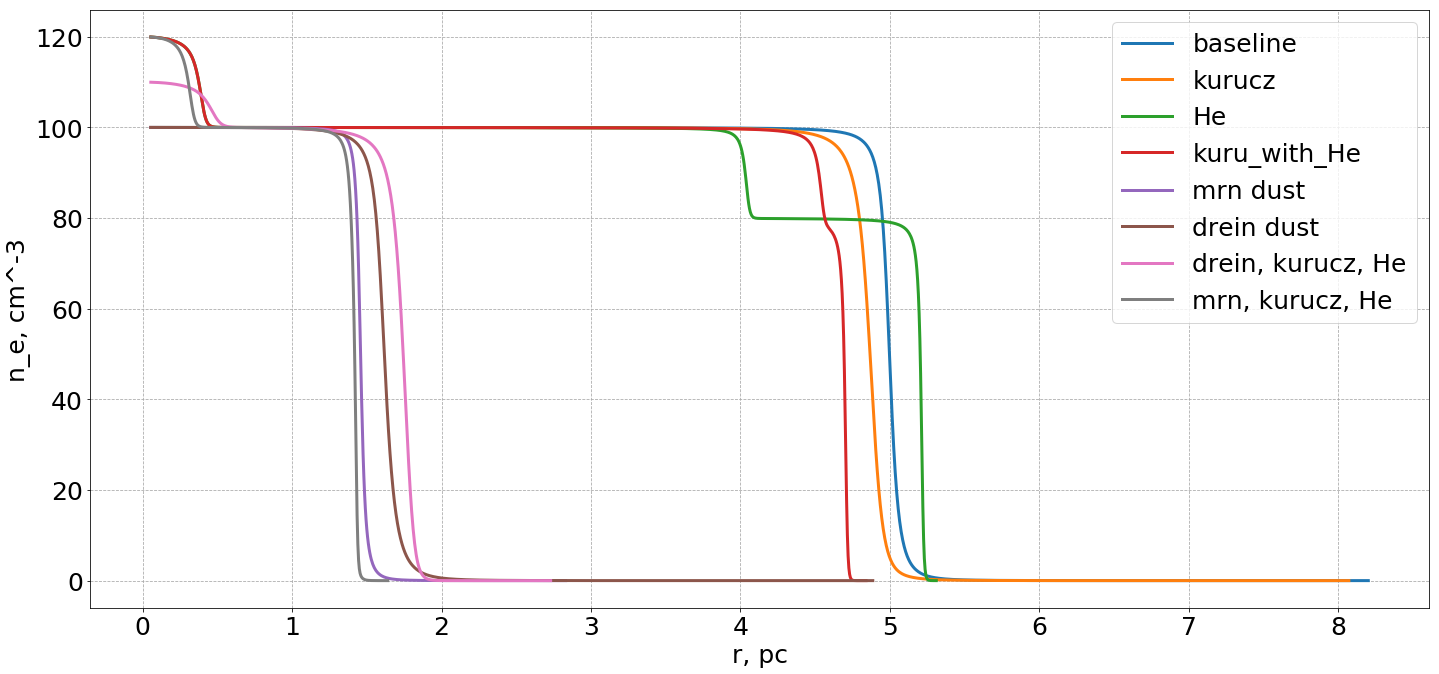

In [13]:
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(24, 11))

for name, result in models_results.items():
    ax.plot(result['r'], result['n_e'], lw=3, label=name) 
    
ax.grid(c='#aaaaaa', ls='--')

ax.set_ylabel("n_e, cm^-3")
ax.set_xlabel("r, pc")
ax.legend(loc='best')

## detailed plot for He or O

In [27]:
result = StarModel(star_params, dust=None, spectrum='planck', is_He_present=True, He_density = 0.1).run()

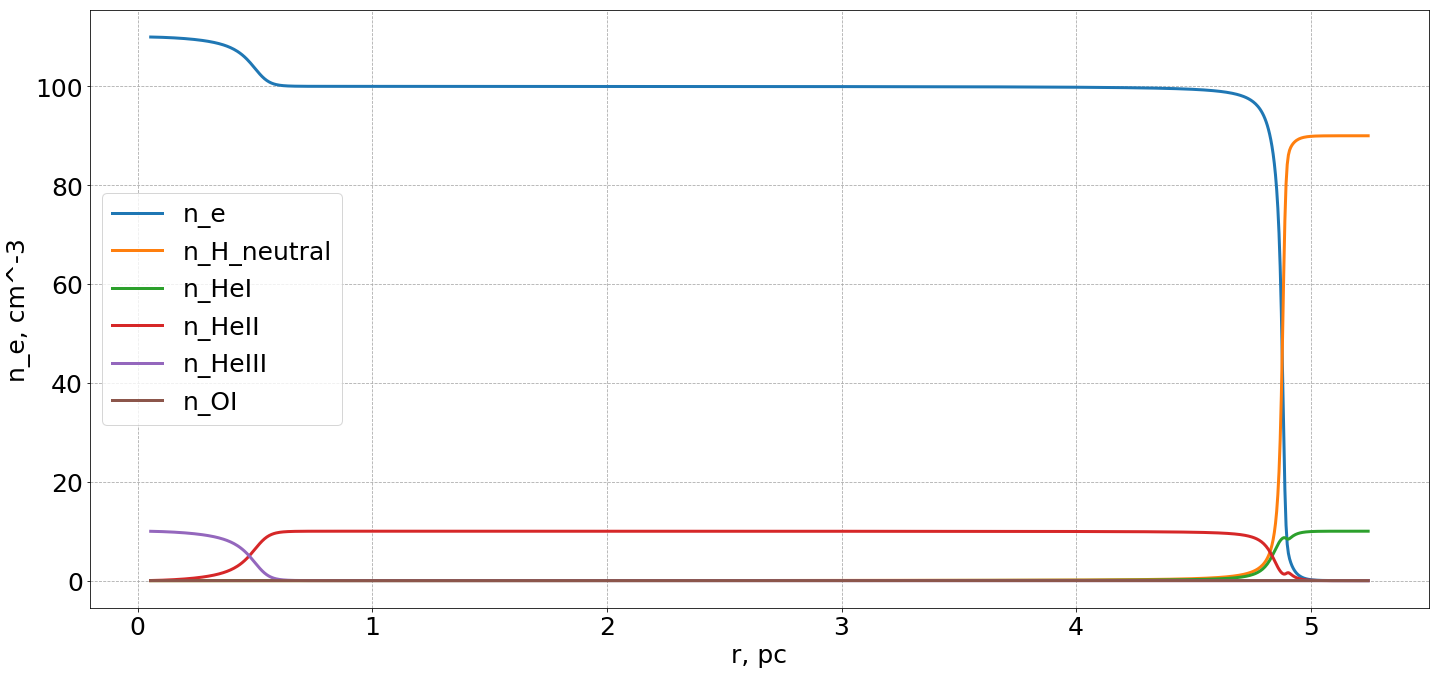

In [30]:
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize=(24, 11))

ax.plot(result['r'], result['n_e'], lw=3) 
ax.plot(result['r'], result['n_H_neutral'], lw=3) 
ax.plot(result['r'], result['n_HeI'], lw=3)
ax.plot(result['r'], result['n_HeII'], lw=3)
ax.plot(result['r'], result['n_HeIII'], lw=3)
ax.plot(result['r'], result['n_OI'], lw=3)
ax.plot(result['r'], result['n_OII'], lw=3)
ax.plot(result['r'], result['n_OIII'], lw=3)
ax.plot(result['r'], result['n_OIV'], lw=3)
    
ax.grid(c='#aaaaaa', ls='--')

ax.set_ylabel("n_e, cm^-3")
ax.set_xlabel("r, pc")
ax.legend(loc='best')

## models with different Helium fraction

In [9]:
He_densities = np.arange(0, 0.5, 0.05)
results = [StarModel(star_params, is_He_present=True, He_density=x).run()
           for x in He_densities]

## animate all models with Helium

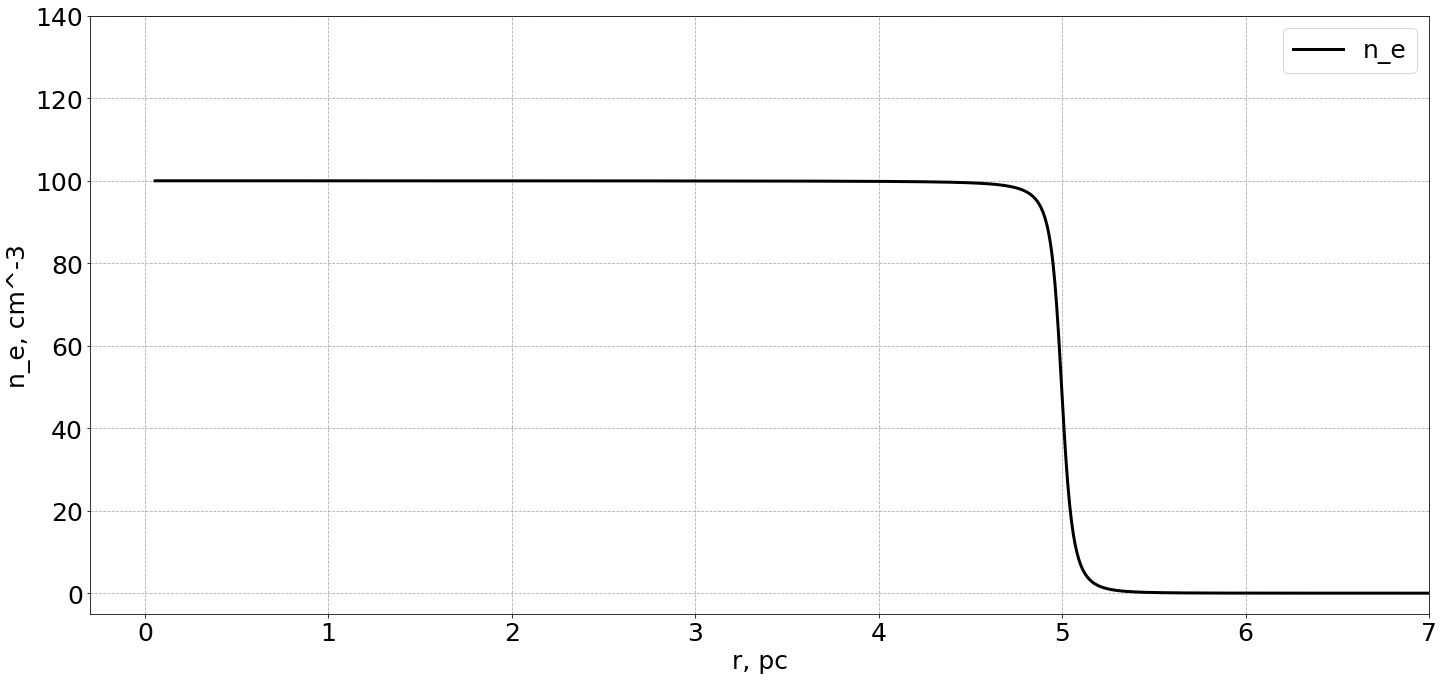

In [10]:
from matplotlib import animation

fig, ax = plt.subplots(figsize=(24, 11))
ax.axis([-0.3, 7, -5, 140])

l, = ax.plot(results[0]['r'], results[0]['n_e'], lw=3, color='black')

ax.grid(c='#aaaaaa', ls='--')

ax.set_ylabel("n_e, cm^-3")
ax.set_xlabel("r, pc")
ax.legend(loc='best')

def animate(i):
    l.set_data(results[i]['r'], results[i]['n_e'])

ani = animation.FuncAnimation(fig, animate, frames=len(results), interval=40)

from IPython.display import HTML
HTML(ani.to_jshtml())

In [9]:
results

[             PHI_H       PHI_HeI    PHI_HeII  n_H_ionised  n_H_neutral  n_HeI  \
 0     1.345406e+07  2.851537e+06  515.004208    99.999993     0.000007    0.0   
 1     1.111905e+07  2.356642e+06  425.623342    99.999991     0.000009    0.0   
 2     9.343089e+06  1.980234e+06  357.641838    99.999989     0.000011    0.0   
 3     7.960971e+06  1.687300e+06  304.736242    99.999987     0.000013    0.0   
 4     6.864302e+06  1.454865e+06  262.757271    99.999985     0.000015    0.0   
 5     5.979565e+06  1.267349e+06  228.890779    99.999983     0.000017    0.0   
 6     5.255472e+06  1.113881e+06  201.173537    99.999981     0.000019    0.0   
 7     4.655362e+06  9.866902e+05  178.202164    99.999979     0.000021    0.0   
 8     4.152463e+06  8.801031e+05  158.951930    99.999976     0.000024    0.0   
 9     3.726859e+06  7.898985e+05  142.660458    99.999973     0.000027    0.0   
 10    3.363486e+06  7.128832e+05  128.751063    99.999970     0.000030    0.0   
 11    3.050776e